In [1]:
import os
import sys

In [2]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, lr_scheduler
import torchvision
import torchvision.transforms as T

In [3]:
BATCH_SIZE = 512

In [4]:
from ffcv.fields import IntField, RGBImageField
from ffcv.fields.decoders import IntDecoder, SimpleRGBImageDecoder
from ffcv.loader import Loader, OrderOption
from ffcv.pipeline.operation import Operation
from ffcv.transforms import RandomHorizontalFlip, Cutout, \
    RandomTranslate, Convert, ToDevice, ToTensor, ToTorchImage
from ffcv.transforms.common import Squeeze

# Note that statistics are wrt to uint8 range, [0,255].
CIFAR_MEAN = [125.307, 122.961, 113.8575]
CIFAR_STD = [51.5865, 50.847, 51.255]

loaders = {}
for name in ['train', 'test']:
    label_pipeline = [IntDecoder(), ToTensor(), ToDevice('cuda:1'), Squeeze()]
    image_pipeline = [SimpleRGBImageDecoder()]

    # Add image transforms and normalization
    if name == 'train':
        image_pipeline.extend([
            RandomHorizontalFlip(),
            RandomTranslate(padding=4),
            Cutout(16, tuple(map(int, CIFAR_MEAN))),
        ])
    image_pipeline.extend([
        ToTensor(),
        ToDevice('cuda:1', non_blocking=True),
        ToTorchImage(),
        Convert(torch.float16),
        T.Normalize(CIFAR_MEAN, CIFAR_STD),
    ])

    # Create loaders
    order_opt = OrderOption.RANDOM if name == 'train' else OrderOption.SEQUENTIAL
    loaders[name] = Loader(f'/tmp/cifar_{name}.beton',
                            batch_size=BATCH_SIZE,
                            num_workers=8,
                            order=order_opt,
                            drop_last=(name == 'train'),
                            pipelines={'image': image_pipeline,
                                       'label': label_pipeline})

In [5]:
from torch import nn
import torch.nn.functional as F

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)

In [6]:
model = ResNet18().cuda(1)

# lr = 0.5 * BATCH_SIZE/512
lr = 0.4

EPOCHS = 200

ne_iters = 50000 // BATCH_SIZE
lr_schedule = np.interp(np.arange(1+EPOCHS*ne_iters),
                        [0, 5*ne_iters, EPOCHS*ne_iters],
                        [0, 1, 0])
optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_schedule.__getitem__)

scaler = GradScaler()
loss_fn = CrossEntropyLoss(label_smoothing=0.1)

losses = []
for epoch in tqdm(range(EPOCHS)):
    for i, (inputs, labels) in enumerate(loaders['train']):
        optimizer.zero_grad(set_to_none=True)
        with autocast():
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
        losses.append(loss.item())
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

  6%|█████████▋                                                                                                                                                        | 3/50 [00:12<03:10,  4.05s/it]

KeyboardInterrupt



In [11]:
def evaluate(model):
    model.eval()
    correct = 0
    with torch.no_grad(), autocast():
        for batch in tqdm(loaders['test']):
            inputs, labels = batch
            outputs = model(inputs.cuda(1))
            pred = outputs.argmax(dim=1)
            correct += (labels == pred).sum().item()
    return correct
evaluate(model)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 113.48it/s]


9470

In [12]:
def save_model(model, i):
    sd = model.state_dict()
    torch.save(model.state_dict(), 'resnet18_%s.pth.tar' % i)
save_model(model, 'net21')

In [13]:
def viz(w, show=True):
    w = w.detach().cpu()
#     print(w.min(), w.max() - w.min())
#     w = w - w.min()
#     w = w / w.max()
    w = (w + 1.0) / 2.0
    
    if len(w.shape) == 3:
        w = w.unsqueeze(0)
    if w.shape[0] > 1:
        w = torchvision.utils.make_grid(w)
    else:
        w = w.squeeze(0)
    w = w.permute(1, 2, 0)
    if show:
        plt.figure(figsize=(10, 10))
        plt.imshow(w)
        plt.axis('off')
        plt.show()
    else:
        return w

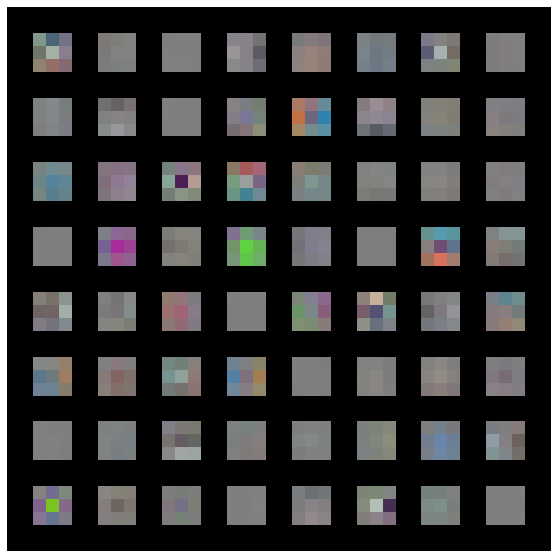

In [14]:
viz(model.conv1.weight)

In [15]:
(model.conv1.weight.data.abs().reshape(64, -1).sum(1) > 1e-4).float().sum().item()

64.0

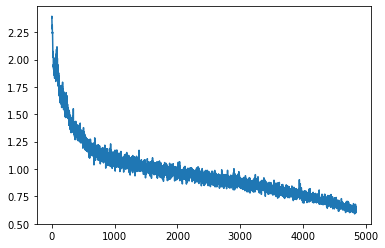

In [16]:
plt.plot(losses)
plt.show()